In [92]:
%matplotlib inline
import qutip as qt
import numpy as np
import scipy
from scipy import constants
import itertools
import math

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from systemConst import Tunabletransmon,QQ,iniState1Qsys,iniState2Qsys

pi = np.pi
e = constants.e
h = constants.h
hbar = constants.hbar
ep0 = constants.epsilon_0
mu0 = constants.mu_0

In [93]:
####### Hamiltonian term generators #######
def ket(Nq, i):
    return qt.basis(Nq, i)

def jj(Nq, lv):
    ket = qt.basis(Nq, lv)
    return ket * ket.dag()

def Delta_q(wqs:list, wd, j):
    return wqs[j] - j * wd

def Hq(Nq, wqs:list):
    Hqs = 0
    for i in range(Nq):
        Hqs = Hqs + wqs[i] * jj(Nq, i)
    return Hqs
    
def Hq_rot(Nq, wqs:list, wd):
    Hqr = 0
    for i in range(Nq):
        D = Delta_q(wqs, wd, i)
        Hqr = Hqr + D * jj(Nq, i)
    return Hqr

def _jj1(Nq, i):
    # for taransmon's destroy operator
    ket_low = qt.basis(Nq, i)
    bra_high = qt.basis(Nq, i+1).dag()
    return ket_low * bra_high

def c(Nq):
    # taransmon's destroy operator
    cc = 0
    for i in range(Nq-1):
        cc = cc + np.sqrt(i + 1) * _jj1(Nq, i)
    return cc

######### N-level paulis #########
def pI_N(Nq):
    return ket(Nq, 0) * ket(Nq, 0).dag() + ket(Nq, 1) * ket(Nq, 1).dag()

def pX_N(Nq):
    return ket(Nq, 0) * ket(Nq, 1).dag() + ket(Nq, 1) * ket(Nq, 0).dag()

def pY_N(Nq):
    return 1j*ket(Nq, 0) * ket(Nq, 1).dag() - 1j*ket(Nq, 1) * ket(Nq, 0).dag()

def pZ_N(Nq):
    return ket(Nq, 0) * ket(Nq, 0).dag() - ket(Nq, 1) * ket(Nq, 1).dag()

######### N-level Single qubit rotation #########
def RX(theta, Nq, Nf):
    x = pX_N(Nq) * (-1j*theta/2)
    return qt.tensor(x.expm(), qt.qeye(Nf))

def RY(theta, Nq, Nf):
    y = pY_N(Nq) * (-1j*theta/2)
    return qt.tensor(y.expm(), qt.qeye(Nf))

def RZ(theta, Nq, Nf):
    z = pZ_N(Nq) * (-1j*theta/2)
    return qt.tensor(z.expm(), qt.qeye(Nf))

####### Plot utility functions #######
def evals(ini_state, props, e_ops):
    # 与えられた演算子に対する期待値のリストを返す
    
    # 例 
    # input : e_ops = [A, B, C] -> output : [[A-evals], [B-evals], [C-evals]] 
    
    # ini_stateは密度行列で渡す
    # propsは超演算子として渡す
    # e_opsはリストで渡す
    es = []
    for i in range(len(e_ops)):
        ee = []
        for j in range(len(props)):
            r = props[j] * qt.operator_to_vector(ini_state)
            rr = qt.vector_to_operator(r)
            e = qt.expect(e_ops[i], rr).real #qt.expect(ope,state)で期待値
            ee.append(e)
        es.append(ee)
    return es

def bloch(evals):
    # ブロッホ球を描画するだけ
    b = qt.Bloch()
    
    b.add_vectors([evals[0][0], evals[1][0], evals[2][0]])
    b.add_vectors([evals[0][-1], evals[1][-1], evals[2][-1]])
    b.add_points(evals, meth='l')
    b.make_sphere()

    b.show()

    
######## Calc. Propagator ######## ( wrapper of qutip.propagator() )
def simple_prop(H, t_list, c_ops, p_args, mode, steps=10000):
    # 散逸がある場合とない場合でqt.propagatorの返す形式が異なるので、その違いを吸収する。
    # どちらの場合も超演算子形式で返すようにする。
    if mode == 'sch':
        _res = qt.propagator(H, t_list, c_ops=[], args=p_args, parallel=False, options=qt.Options(nsteps=steps))
        res = []
        for i in range(len(_res)):
            sp = qt.to_super(_res[i])
            res.append(sp)
        res = np.array(res)
    elif mode == 'lind':
        res = qt.propagator(H, t_list, c_ops, args=p_args, parallel=False, options=qt.Options(nsteps=steps))
    
    return res

## Fidelity utility
---
Ref : [Direct Fidelity Estimation from Few Pauli Measurements](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.106.230501)

\begin{align}
    d &= 2^n, n : qubits \\
    \mathcal{U} &: ideal\,channel,\;\; \mathcal{E} : exp.\,channel \\
    \chi_\mathcal{U}(k, k') &= \frac{1}{d}\mathrm{Tr}[W_k \mathcal{U}(W_k')] \\
    X &= \chi_\mathcal{E}(k, k') / \chi_\mathcal{U}(k, k') \\
    Pr(k,k') &= \frac{1}{d^2}\left[ \chi_\mathcal{U}(k, k') \right]^2 \\
    F_e &= {\mathrm{Tr}[\mathcal{U}^\dagger \mathcal{E}]}{d^2} \\
    F_e &= expe.X = \sum_{k, k'}X_{k, k'} Pr(k,k')\\
    F_{avg} &= \frac{d*F_e+1}{d+1}
\end{align}

In [94]:
def paulis_set(Nq):
   
    pauli = [pI_N(Nq), pX_N(Nq), pY_N(Nq), pZ_N(Nq)]
    p_list = list(itertools.product(pauli, repeat=1))      
    W_set = []
    for k in range(len(p_list)):
        ps = p_list[k]
        w = ps[0]
        for l in range(1, len(ps)):
            w = qt.tensor(w, ps[l])
        W_set.append(w)
    return W_set

#print(len(paulis_set(3,2))) =16

# for One qubit gates
def _tr(Ope, p, q, paulis, Nq):
    
    Wp = paulis[p]
    Wq = paulis[q]
    Wq_vec = qt.operator_to_vector(Wq)
    b = (Ope * Wq_vec)
    c = qt.vector_to_operator(b)
    a = Wp * c
    mat = a.full()
    return abs(mat[0][0] + mat[1][1])

def agf(Ope, target, Nq):
    d = 2
    paulis = paulis_set(Nq)
    eX = []
    P = []
    for p in range(len(paulis)):
        for q in range(len(paulis)):
            e = _tr(Ope, p, q, paulis, Nq)/d
            u = _tr(target, p, q, paulis, Nq)/d
            prb = (1/(d**2)) * u**2
            P.append(prb)
            if u != 0:
                eX.append((e/u)*prb)
            else:
                eX.append(0)
    Fe = np.sum(eX)
    Fave = (d * Fe+1)/(d+1)
    return Fave, Fe, np.sum(P)

## Pulse shape
---

In [95]:
def square(Tg, scale=1):
    return np.ones(Tg) * scale

def gaussian(Tg, sigma, nPoints, scale=1, fs=1, PLOT=False):
    shape = np.zeros(nPoints)
    for i in range(nPoints):
        x = i * (1/fs) # 1/fs [ns]
        a = scale * np.exp(- (x - Tg/2)**2 / (2*sigma**2))
        shape[i] = round(a, 15)
    if PLOT:
        plt.figure()
        plt.plot(np.linspace(0, Tg, nPoints), shape, 'o', markersize=2)
        plt.show()
    return shape

def flatTopGaussian(Tg, sigma, edgeLen, scale=1, fs=1, PLOT=False):
    nPoints = Tg
    shape = np.zeros(nPoints)
    for i in range(nPoints):
        x = i * (1/fs) # 1/fs [ns]
        if x < edgeLen:
            a = scale * np.exp(- (x - (edgeLen))**2 / (2*sigma**2))
        elif x > Tg-edgeLen-1:
            a = scale * np.exp(- (x - (Tg-edgeLen-1))**2 / (2*sigma**2))
        else:
            a = scale * 1
        shape[i] = round(a, 15)
    if PLOT:
        plt.figure()
        plt.plot(np.linspace(0, Tg, nPoints), shape)
        plt.show()
    return shape

def sech_pulse(gt, sigma, points=100, scale=1, PLOT=False):
    t = np.linspace(0, gt, points)
    shape = scale / np.cosh(sigma*(t-gt/2))
    if PLOT:
        plt.figure()
        plt.plot(t, shape)
        plt.show()
    return shape

def MW_shaped(t, args):
    shape = args['shape']
    amp = args['mwamp']
    if len(shape) == int(t):
        n = int(t) - 1
    else:
        n = int(t)
    return amp * shape[n]

## Parameters
---

In [96]:
# Q
Ej = 22
Ec = 0.27

###### qubit [GHz] ######
Nq = 3
Q = Tunabletransmon(EC=Ec,EJmax=Ej,Nq=Nq)
wqs=Q.enes

## Hamiltonian assembling
---

In [97]:
i = qt.qeye(2)
x = qt.sigmax()
y = qt.sigmay()
z = qt.sigmaz()
sp = qt.sigmap()
sm = qt.sigmam()

Iq = qt.qeye(Nq)
pI = pI_N(Nq)
px = pX_N(Nq)
py = pY_N(Nq)
pz = pZ_N(Nq)

e_ops = [px, py, pz]

ini_state=(px+pI)/2
###### Assembling Lab frame Hamiltonian ######
q_lab = Hq_rot(Nq, wqs, 0)

###### Calc. Drive frequency ######
eigenE = q_lab.eigenenergies()
wd = eigenE[1]

#Hq1_rot = Hq_rot(Nq, wqs, wd)
Hq1_rot = Hq_rot(Nq, wqs, wd)
Hq_t_dep = qt.qdiags(np.arange(0,Q.Nq,1),0)#Hq2_rot(modulation term)
H_rot = [Hq1_rot, [Hq_t_dep, MW_shaped]]

In [98]:
###### Gate time ######
mwamp = -0.31
Tg = int(pi/abs(mwamp)) # [ns]
print(Tg)

sigma = 10
edge = sigma*2

squ = square(Tg, scale=1)
gau = gaussian(Tg, sigma, Tg, scale=1, fs=1, PLOT=False)
ftg =  flatTopGaussian(Tg, sigma, edge, scale=1)
sech = sech_pulse(Tg, 0.2, points=Tg, scale=1)

args = {'mwamp':mwamp, 'shape':squ}
t_step = Tg
t_list = np.linspace(0, Tg, Tg+1)

10


In [99]:
res = simple_prop(H_rot, t_list, [], args, 'sch')
#res = qt.propagator(H_rot, t_list,[],args, parallel=False, options=qt.Options(nsteps=1000))

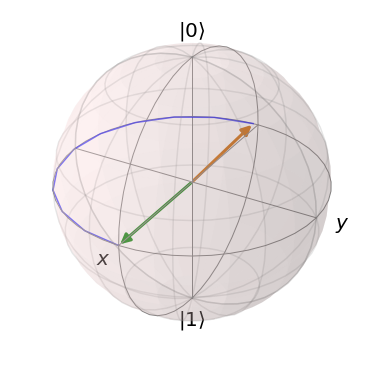

[[1.0, 0.9523335753372373, 0.8138784661585143, 0.5978339940557531, 0.32479629675039784, 0.020794839400410166, -0.285189049465499, -0.5639850505292753, -0.7890147428575536, -0.9388254023940621, -0.9991351501004102], [0.0, -0.30505861942484835, -0.5810351472359172, -0.8016199321070715, -0.9457839952215451, -0.9997837639481405, -0.9584712859887693, -0.8257849979137977, -0.6143742634204565, -0.3443934723824297, -0.041580666587138805], [0.0, 1.1102230246251565e-16, 0.0, -1.1102230246251565e-16, -1.1102230246251565e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


In [100]:
bloch(evals(ini_state, res, e_ops))
print(evals(ini_state, res, e_ops))

## Fidelity

In [101]:
target = qt.to_super(pz)
Fave, Fe, prb = agf(res[-1], target, Nq)
print('Fave = '+'{:.2f}'.format(Fave*100))

Fave = 99.97
